C:\Users\laric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



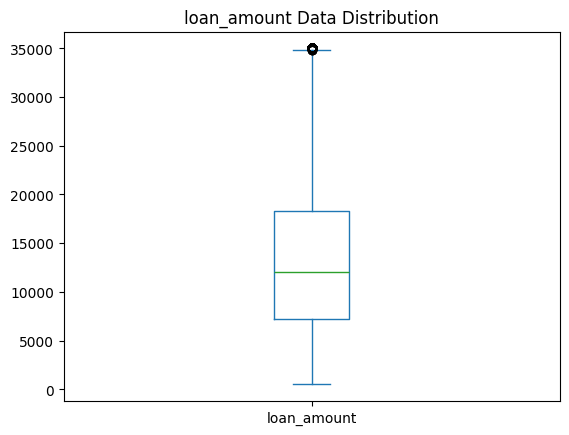

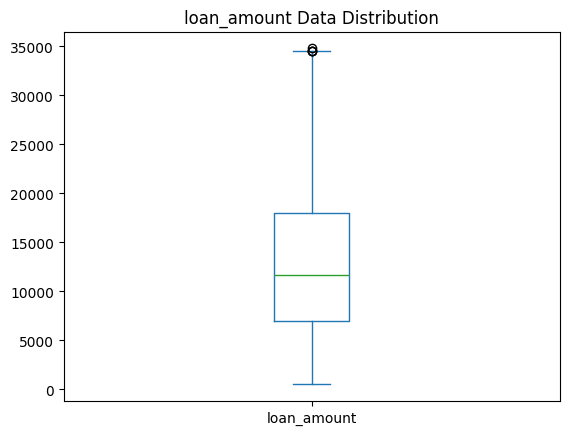

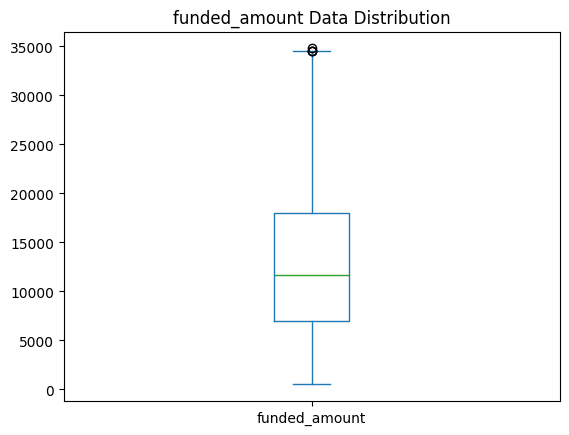

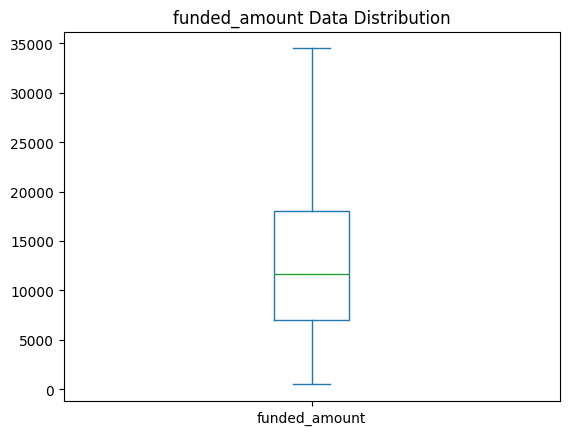

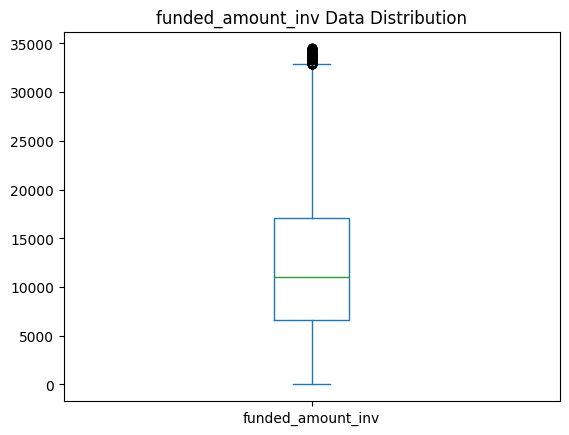

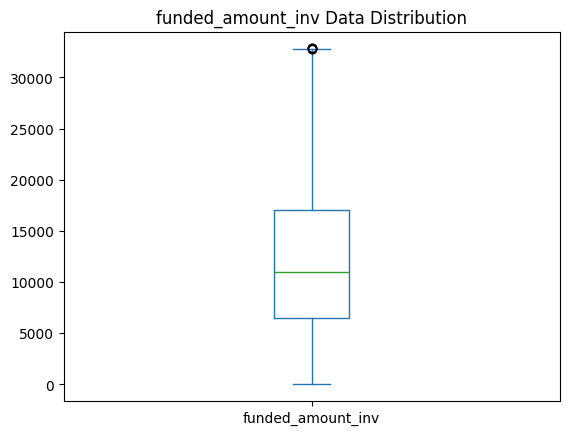

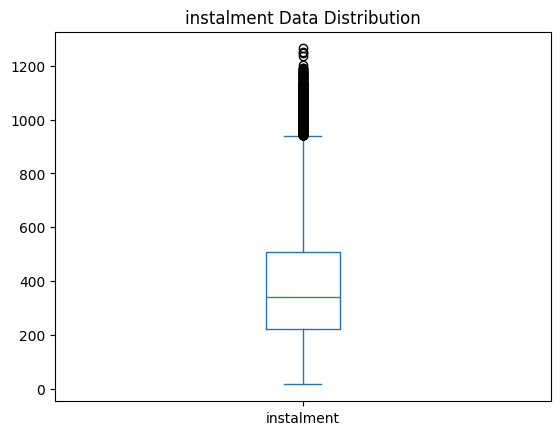

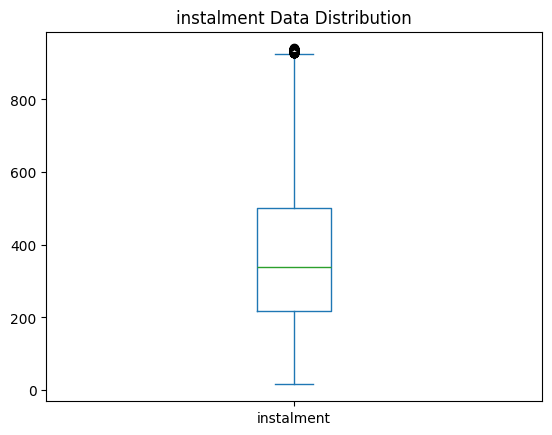

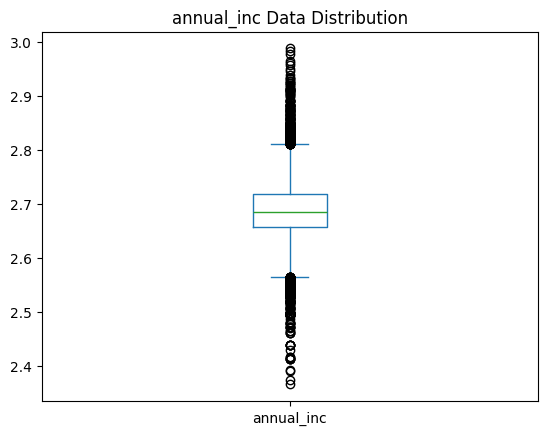

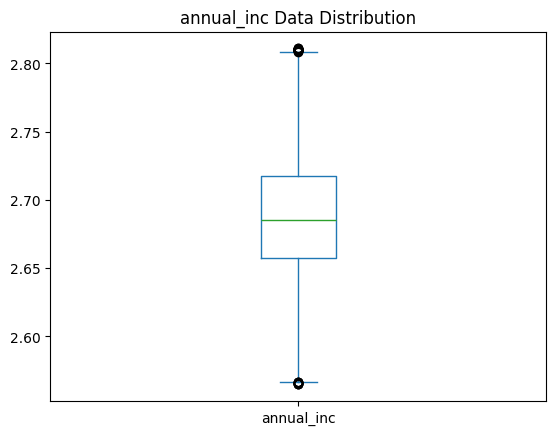

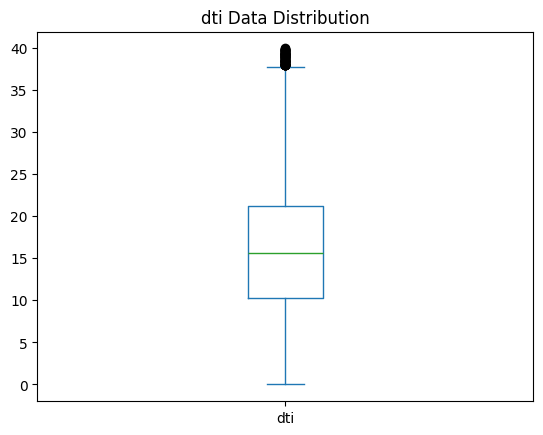

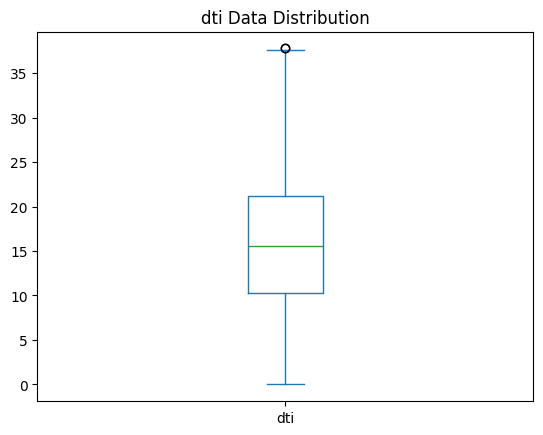

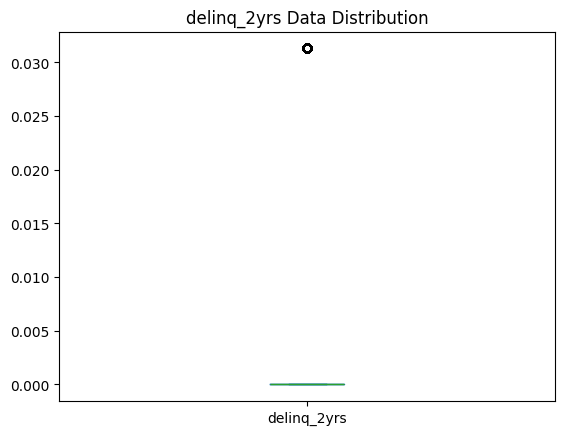

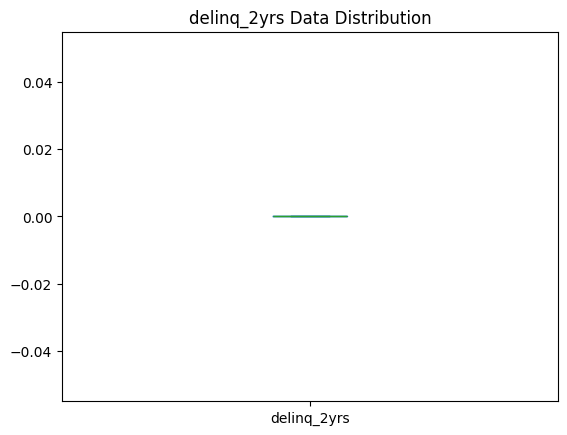

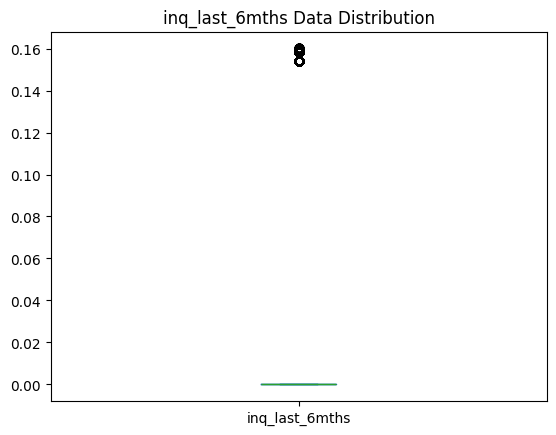

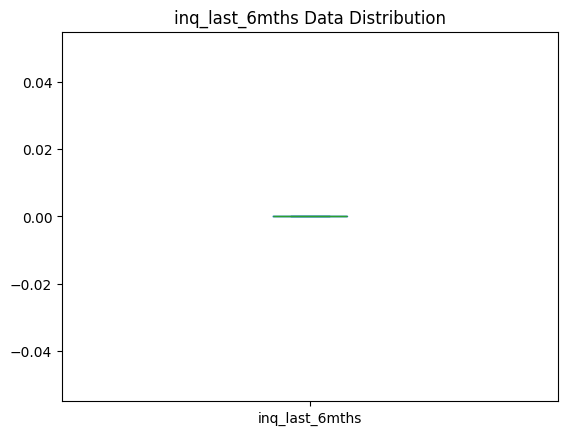

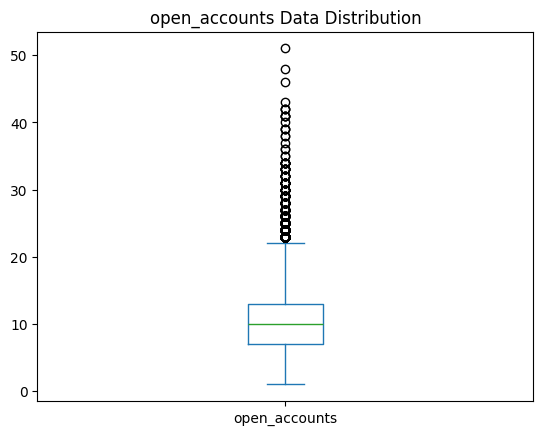

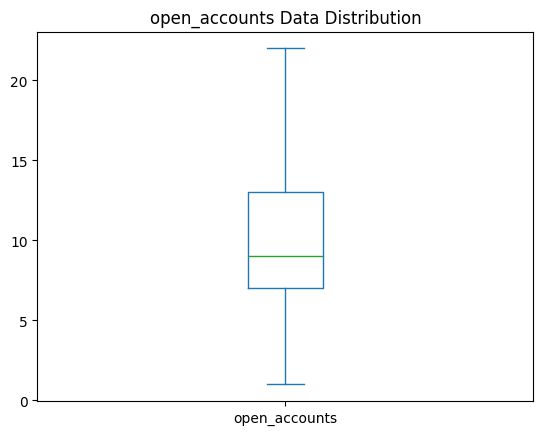

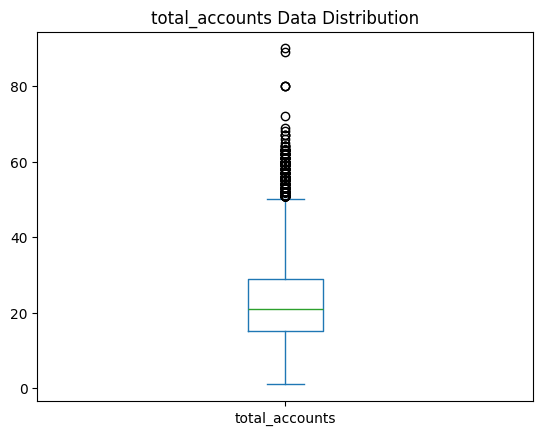

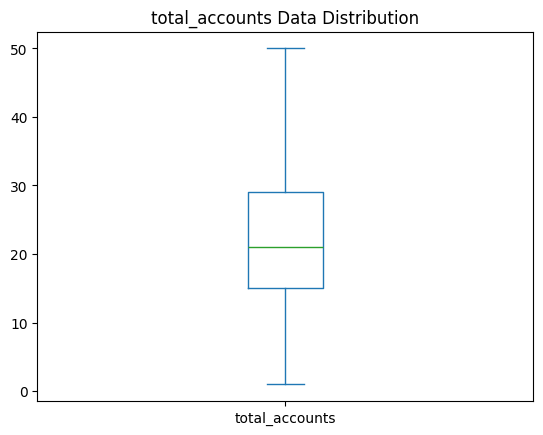

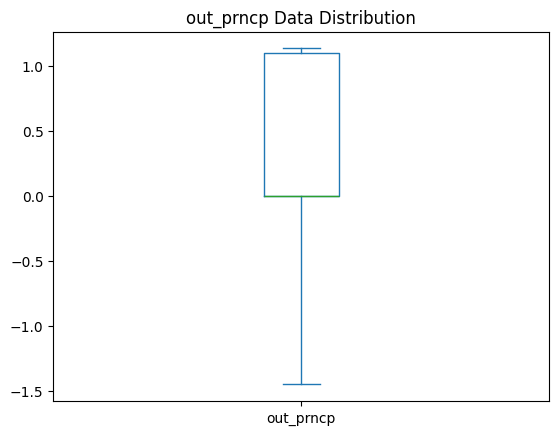

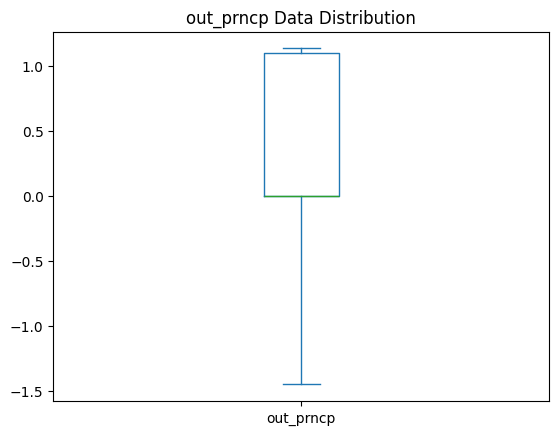

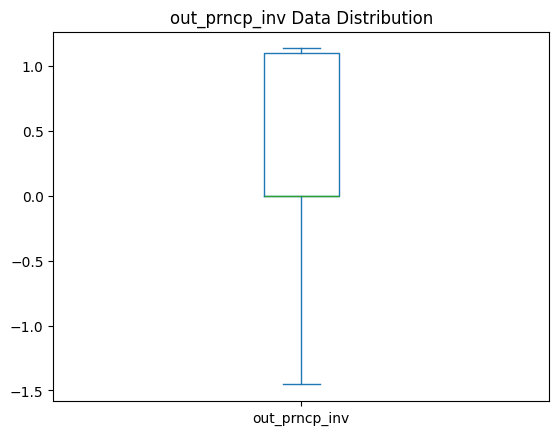

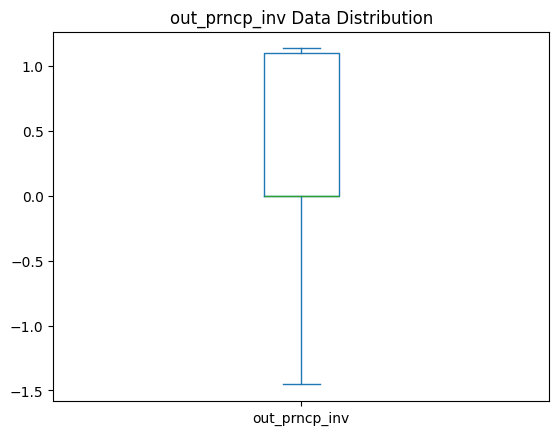

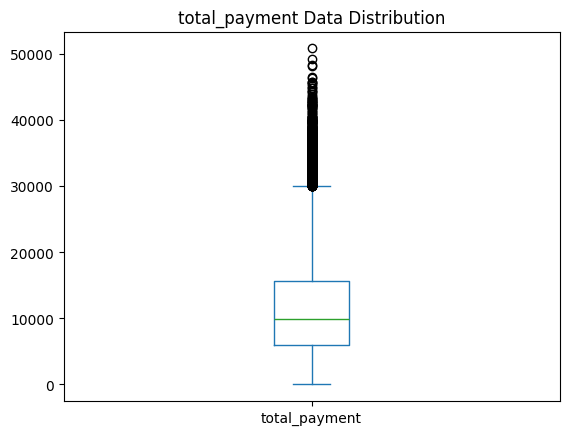

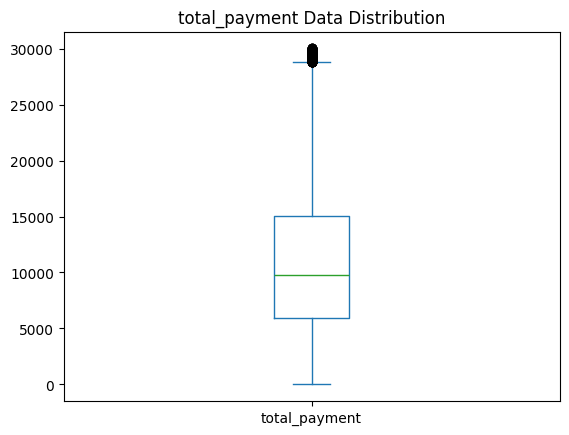

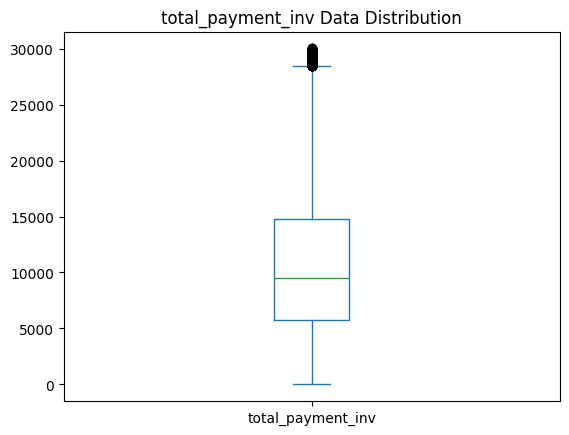

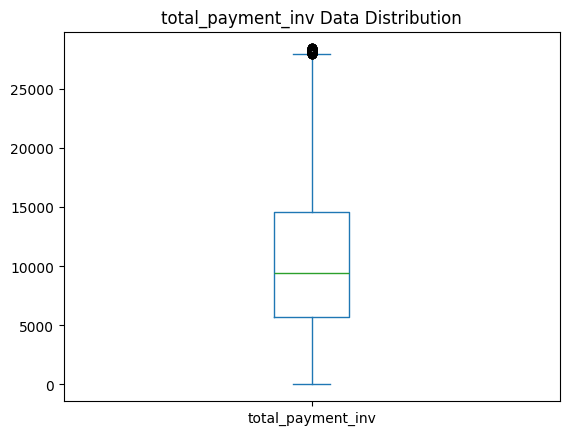

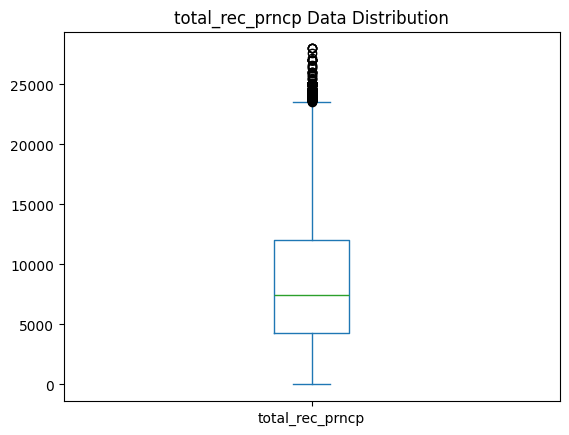

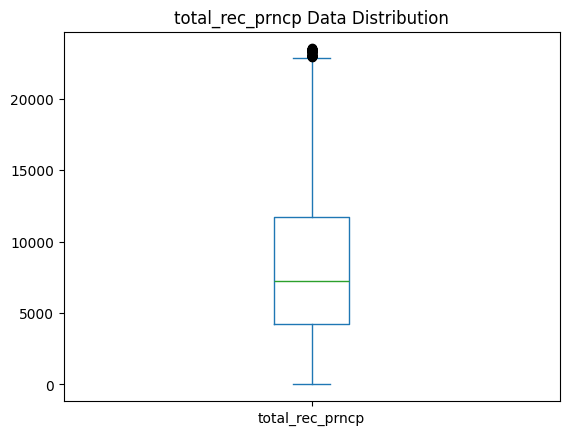

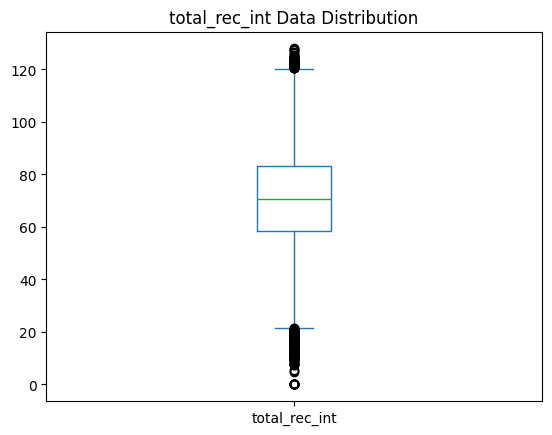

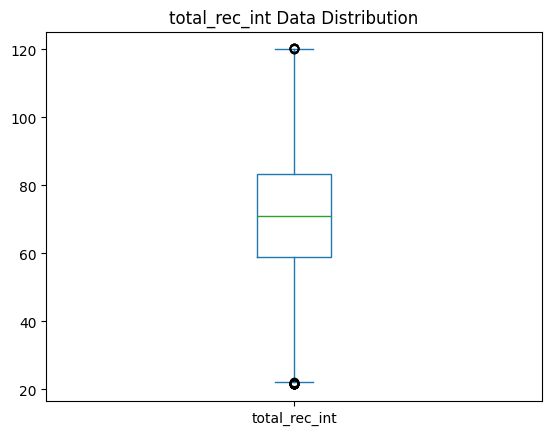

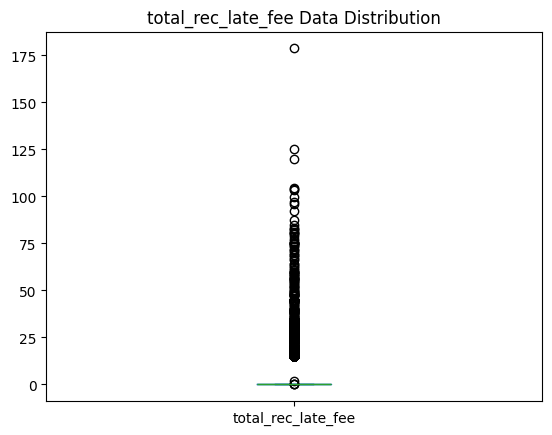

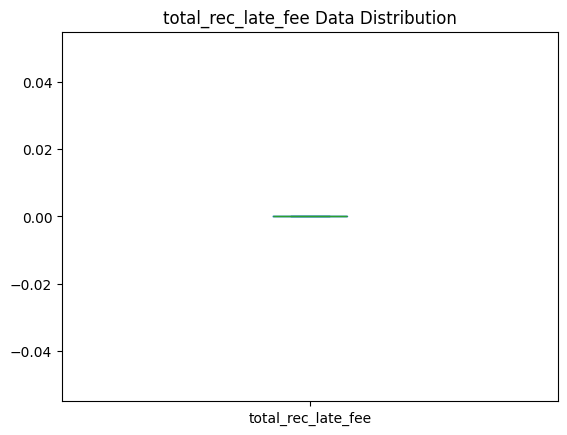

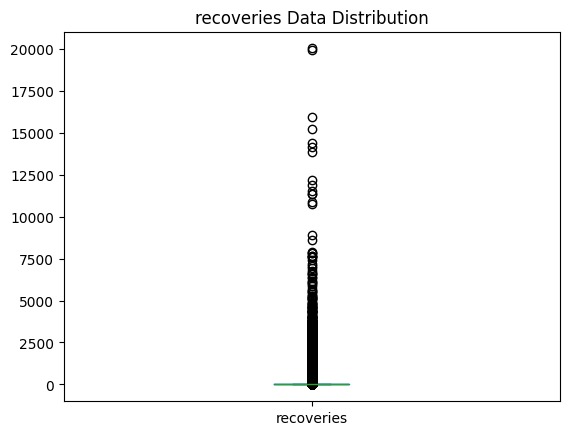

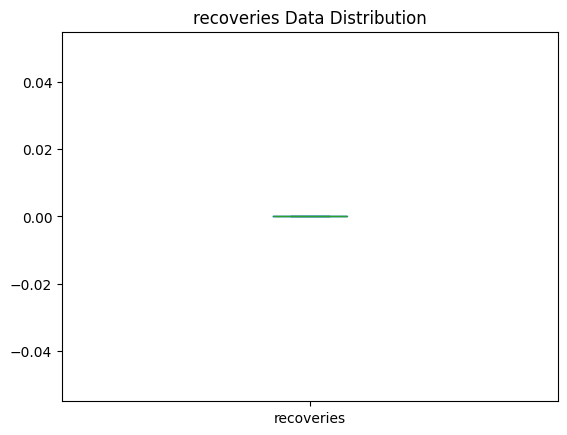

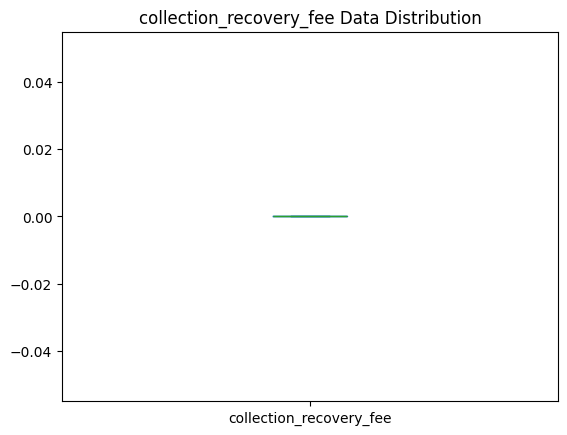

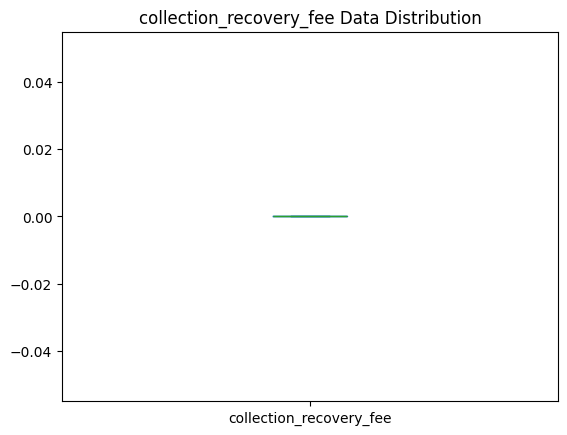

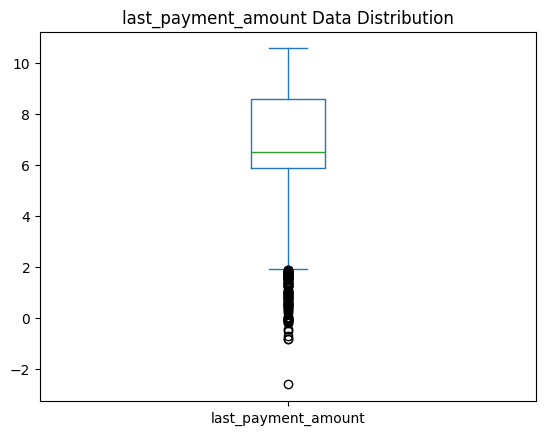

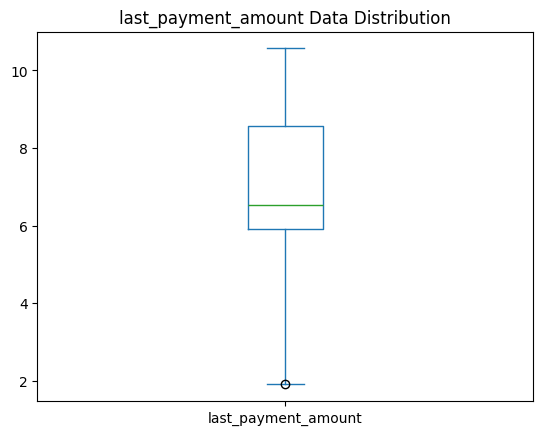

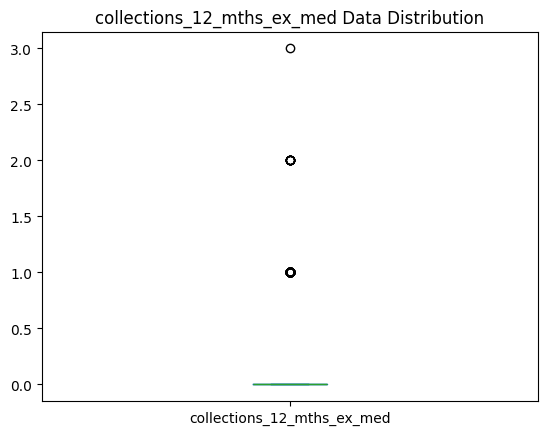

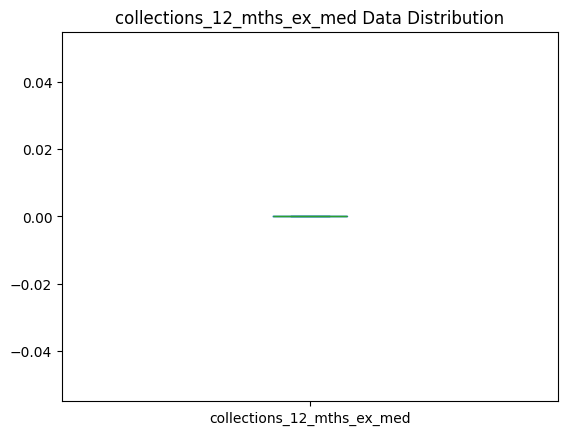

In [14]:
import db_utils
import yaml, pandas as pd, numpy as np, plotly.express as px, plotly.io as pio
pio.renderers.default = "notebook"

'''
Loading the data in the yaml file and saving it as 
a csv file on the local machine
'''

with open('credentials.yaml') as file:
    credentials_dict = yaml.safe_load(file)
    
credentials = db_utils.RDSDatabaseConnector(credentials_dict)
loan_payments = credentials.initialise_database()
credentials.save_file(loan_payments, 'new_file.csv')


'''
Loading the data and adjusting the data types of each column of the dataframe
where needed as well as ensuring the formatting of the data (specifically those 
that consist of dates) are all the same
'''

database = db_utils.load_csv('new_file.csv')
data_transform = db_utils.DataTransform(database)

date_data = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date',
             'last_credit_pull_date']

categorical_data = ['member_id', 'term', 'int_rate', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 
                    'payment_plan', 'purpose', 'policy_code', 'application_type']

non_numeric_data = date_data + categorical_data 
column_headings = database.columns.values.tolist()
numeric_data = [column for column in column_headings if column not in non_numeric_data]

for date_column in date_data:
    database, date_column = data_transform.date_data(database, date_column)

for categories in categorical_data:
    database, categories = data_transform.change_type(database, categories, 'category')


'''
Dropping columns whose data consists of more than 50% of null values
and filling in the null values for the other columns with null values
'''

df_info = db_utils.DataFrameInfo(database)
df_transform = db_utils.DataFrameTransform(database)
df_plot = db_utils.Plotter(database)

for column in column_headings:
    null_vals, null_percentage = df_info.missing(database, column)
    if null_percentage > float(50):
        database = database.drop(column, axis=1)

database = database.sort_values(by=['sub_grade'])
database['int_rate'] = database['int_rate'].ffill()
database['funded_amount'] = database.loc[:, 'loan_amount']
fill_values = {'collections_12_mths_ex_med': 0, 'term': database['term'].mode()[0]}
database = df_transform.fill_null(database, values= fill_values)

database, collections_12_mths_ex_med = data_transform.change_type(database, 'collections_12_mths_ex_med', 'int')

last_payment_date_list= db_utils.make_list(database, 'last_payment_date')
last_credit_pull_date_list = db_utils.make_list(database, 'last_credit_pull_date')
collections_list = db_utils.make_list(database, 'collections_12_mths_ex_med')

for index in range(database.shape[0]):
    if pd.isnull(collections_list[index]):
        if last_payment_date_list[index] != 'NaT':
            collections_list[index] += 1

    if pd.isnull(last_payment_date_list[index]):
        last_payment_date_list[index] = last_credit_pull_date_list[index]
    
    if pd.isnull(last_credit_pull_date_list[index]):
        last_credit_pull_date_list[index] = last_payment_date_list[index]

database['last_payment_date'] = last_payment_date_list
database['last_credit_pull_date'] = last_credit_pull_date_list
database['collections_12_mths_ex_med'] = collections_list
database = database.dropna(axis = 0)


'''
Finding the skew of the columns made of integers and floats in the
dataframe
'''

unskewed_data = database.copy()

original_skews = df_info.df_skew(database)
skewed_data = database[[cols for cols, skews in original_skews.items() if skews > 2]]
log_skewed_data = yeojohnson_skew = boxcox_skew = skewed_data.copy()

log_skewed_data = df_transform.log_transform(log_skewed_data)
yeojohnson_skew = df_transform.yeojohnson_transform(yeojohnson_skew)
boxcox_skew = df_transform.boxcox_transform(boxcox_skew)

log_skew = df_info.df_skew(log_skewed_data)
yeo_skew = df_info.df_skew(yeojohnson_skew)
box_skew = df_info.df_skew(boxcox_skew)

for column in skewed_data.columns:
    col_skew = abs(original_skews.get(column))
    log_col_skew = abs(log_skew[column])
    yeo_col_skew = abs(yeo_skew[column])
    
    smallest_skew = min(log_col_skew, yeo_col_skew, col_skew)

    if column in boxcox_skew.columns:
        box_col_skew = abs(box_skew[column]).all()
        
        if box_col_skew <= smallest_skew:
            unskewed_data.loc[:, column] = boxcox_skew[column].copy()

    if smallest_skew == log_col_skew or smallest_skew == log_col_skew == yeo_col_skew:
        unskewed_data.loc[:, column] = log_skewed_data[column].copy()
    elif smallest_skew == yeo_col_skew:
        unskewed_data.loc[:, column] = yeojohnson_skew[column].copy()

'''
Finding and removing outliers in the data.
'''

for categories in unskewed_data.columns:
    if unskewed_data.dtypes[categories] in ['float64', 'int64']:
        
        q1 = unskewed_data[categories].quantile(0.25)
        q3 = unskewed_data[categories].quantile(0.75)
        iqr = q3 - q1
        unskewed_data = unskewed_data[~((unskewed_data[categories]<(q1-1.5*iqr)) | (unskewed_data[categories]>(q3+1.5*iqr)))]
        unskewed_data = unskewed_data.dropna().reset_index(drop=True)
        #df_plot.plot_boxplot(unskewed_data, categories)
        
#px.imshow(unskewed_data.corr(numeric_only = True), title = 'Heatmap using Pearson correlation coefficient')